In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

/home/ronak/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Taken from Richard's "Reprod Figure 2"

In [3]:
# def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
#     model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
#                               n_estimators = n_estimators, 
#                               max_samples= max_samples, 
#                               bootstrap = bootstrap)
#     model.fit(X, y)
#     class_counts = np.zeros((X.shape[0], model.n_classes_))
#     for tree in model:
#         # get out of bag indicies
        
#         # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
#         #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
#         unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
#         # RONAK EDIT ENDS HERE ##################
        
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
#         # get all node counts
#         node_counts = tree.tree_.n_node_samples
#         # get probs for eval samples
#         posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
#         for prob_index in prob_indices:
#             posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
#         row_sums = posterior_class_counts.sum(axis=1)
#         row_sums[row_sums == 0] = 1
#         class_probs = (posterior_class_counts/row_sums[:, None])
        
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
#         where_1 = np.argwhere(class_probs == 1)
#         for elem in where_1:
#             class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
#         class_probs.tolist()
#         partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
#         # get probability for out of bag samples
#         eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#         eval_class_probs = np.array(eval_class_probs)
#         # find total elements for out of bag samples
#         elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
#         # store counts for each x (repeat fhis for each tree)
#         class_counts[eval_indices] += elems
#     # calculate p(y|X = x) for all x's
#     probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
#     entropies = -np.sum(np.log(probs)*probs, axis = 1)
#     # convert nan to 0
#     entropies = np.nan_to_num(entropies)
#     return np.mean(entropies)

# np.warnings.filterwarnings('ignore')

In [4]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [5]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

In [6]:
# def conditional_entropy_distribution(n, d, frac_eval, algos, num_trials, mu, parallel = False):
#     # For each trial, generate data and compute conditional entropy for each algorithm.
#     def worker(t):
#         # X, y, X_eval = generate_data(n, d, frac_eval, mu = mu)
#         X, y = generate_data(n, d, 0, mu = mu)
#         ret = np.zeros(len(algos))
#         for i in range(len(algos)):
#             obj = algos[i]['instance']
#             if algos[i]['label'] == 'UF':
#                 n_estimators = obj['n_estimators']
#                 ret[i] = cef_estimate(X, y, n_estimators = n_estimators, min_samples_leaf = int(np.log(len(X))))
#             else:
#                 X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
#                 obj.fit(X, y)
#                 p = obj.predict_proba(X_eval)
#                 ret[i] = np.mean(entropy(p.T, base = np.exp(1)))
#         return ret
    
#     if parallel:
#         predicted_cond_entropy = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#     else:
#         predicted_cond_entropy = np.zeros((num_trials, len(algos)))
#         for t in tqdm(range(num_trials)):
#             predicted_cond_entropy[t, :] = worker(t)
            
#     return predicted_cond_entropy

## Compute True Conditional Entropy

In [7]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [8]:
# def conditional_entropy_by_n(sample_sizes, d, frac_eval, algos, num_trials, mu, parallel = False):
#     # Repeat for all 'n', and save output in the 'algos' array.
#     cond_entropy_range = np.zeros((len(sample_sizes), num_trials, len(algos)))
#     for i in range(len(sample_sizes)):
#         cond_entropy_range[i, :, :] = conditional_entropy_distribution(sample_sizes[i], 
#                                                                        d, 
#                                                                        frac_eval, 
#                                                                        algos, 
#                                                                        num_trials, 
#                                                                        mu = mu,
#                                                                        parallel = parallel)
        
#     for j in range(len(algos)):
#         algos[j]['cond_entropy_by_n_d_%d' % d] = cond_entropy_range[:, :, j]
        
#     with open('algos_fig2.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('sample_sizes_d_%d.pkl' % d, 'wb') as f:
#         pickle.dump(sample_sizes, f)
        
#     return algos

In [9]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu):
        
    sample_sizes = pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb'))
    uf = pickle.load(open('uf_by_n_d_%d.pkl' % d, 'rb'))
    cart = pickle.load(open('cart_by_n_d_%d.pkl' % d, 'rb'))
    irf = pickle.load(open('irf_by_n_d_%d.pkl' % d, 'rb'))
    results = [cart, irf, uf]
    
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(results[j], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    results[j][:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [10]:
# def conditional_entropy_by_mu(mus, n, d, frac_eval, algos, num_trials, parallel = False):
#     # Repeat for all 'mu', and save output in the 'algos' array.
#     cond_entropy_range = np.zeros((len(mus), num_trials, len(algos)))
#     for i in range(len(mus)):
#         cond_entropy_range[i, :, :] = conditional_entropy_distribution(n, 
#                                                                        d, 
#                                                                        frac_eval, 
#                                                                        algos, 
#                                                                        num_trials, 
#                                                                        mu = mus[i],
#                                                                        parallel = parallel)      
#     for j in range(len(algos)):
#         algos[j]['cond_entropy_by_mu_d_%d' % d] = cond_entropy_range[:, :, j]
        
#     with open('algos_fig2.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('mus_fig2.pkl', 'wb') as f:
#         pickle.dump(mus, f)
        
#     return algos

In [11]:
def plot_cond_entropy_by_mu(ax, d, n):
    
    mus = pickle.load(open('mus_d_%d.pkl' % d, 'rb'))
    uf = pickle.load(open('uf_by_mu_d_%d.pkl' % d, 'rb'))
    cart = pickle.load(open('cart_by_mu_d_%d.pkl' % d, 'rb'))
    irf = pickle.load(open('irf_by_mu_d_%d.pkl' % d, 'rb'))
    results = [cart, irf, uf]
        
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        ax.plot(mus, 
                np.mean(results[j], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [12]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2, effect_size)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2)
    
    axes[0,0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

In [13]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes):
    
    uf = np.zeros((len(sample_sizes), num_trials))
    cart = np.zeros((len(sample_sizes), num_trials))
    irf = np.zeros((len(sample_sizes), num_trials))
    
    def worker(t):
        # X, y = get_multivariate_sample(elem, d, mean)
        X, y = generate_data(elem, d, mu = mean)
        
        # RICHARD's VERSION ####
        # uf_out = cef_estimate(np.array(X), y, 300, .32, depth = 30) 
        
        # RONAK'S VERSION ######
        uf_obj = UncertaintyForest(n_estimators = 300, base = np.exp(1))
        uf_obj.fit(X, y)
        uf_out = uf_obj.estimate_cond_entropy()
        
        ########################
        
        cart_out = CART_estimate(X, y)
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        irf_obj.fit(X, y)
        p = irf_obj.predict_proba(X_eval)
        irf_out = np.mean(entropy(p.T, base = np.exp(1)))
        
        return (uf_out, cart_out, irf_out)
    
    for i, elem in enumerate(sample_sizes):
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        uf[i, :] = output[:, 0]
        cart[i, :] = output[:, 1]
        irf[i, :] = output[:, 2]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    pickle.dump(uf, open('uf_by_n_d_%d.pkl' % d, 'wb'))
    pickle.dump(cart, open('cart_by_n_d_%d.pkl' % d, 'wb'))
    pickle.dump(irf, open('irf_by_n_d_%d.pkl' % d, 'wb'))

    return uf, cart, irf

In [14]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus):
    
    uf = np.zeros((len(mus), num_trials))
    cart = np.zeros((len(mus), num_trials))
    irf = np.zeros((len(mus), num_trials))
    
    def worker(t):
        # X, y = get_multivariate_sample(elem, d, mean)
        X, y = generate_data(n, d, mu = elem)
        
        # RICHARD's VERSION ####
        # uf_out = cef_estimate(np.array(X), y, 300, .32, depth = 30) 
        
        # RONAK'S VERSION ######
        uf_obj = UncertaintyForest(n_estimators = 300, base = np.exp(1))
        uf_obj.fit(X, y)
        uf_out = uf_obj.estimate_cond_entropy()
        
        ########################
        cart_out = CART_estimate(X, y)
        
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        irf_obj.fit(X, y)
        p = irf_obj.predict_proba(X_eval)
        irf_out = np.mean(entropy(p.T, base = np.exp(1)))
        
        return (uf_out, cart_out, irf_out)
    
    for i, elem in enumerate(mus):
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        uf[i, :] = output[:, 0]
        cart[i, :] = output[:, 1]
        irf[i, :] = output[:, 2]
        
    pickle.dump(mus, open('mus_d_%d.pkl' % d, 'wb'))
    pickle.dump(uf, open('uf_by_mu_d_%d.pkl' % d, 'wb'))
    pickle.dump(cart, open('cart_by_mu_d_%d.pkl' % d, 'wb'))
    pickle.dump(irf, open('irf_by_mu_d_%d.pkl' % d, 'wb'))

    return uf, cart, irf

## Run Experiments and Plot

In [15]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
frac_eval = 0.3
# n_estimators = 200
effect_size = 1
d1 = 1
d2 = 40
n1 = 5000
n2 = 10000
num_trials = 20
sample_sizes_d1 = range(400, 2501, 300)
sample_sizes_d2 = range(400, 10001, 960)

# Algorithms.
algos = [
    {
        # 'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
#         'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
#                                            method='isotonic', 
#                                            cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
#         'instance': {'n_estimators': n_estimators},
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 3
# parallel = False

### Estimated H(Y | X) versus n, d = 1

In [16]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1)

(array([[0.41572962, 0.39010263, 0.44073967, 0.41105884, 0.43560583,
         0.44804389, 0.43040472, 0.4094384 , 0.39095385, 0.42308424,
         0.38864235, 0.44799121, 0.34636077, 0.35395587, 0.37788901,
         0.41896359, 0.40352638, 0.43975507, 0.39144901, 0.38181408],
        [0.41981979, 0.38335412, 0.42262224, 0.42776863, 0.38206572,
         0.36941582, 0.38717348, 0.44580361, 0.40109147, 0.44564059,
         0.42120857, 0.41347238, 0.33839677, 0.36900491, 0.3861588 ,
         0.38613335, 0.38192751, 0.40463994, 0.38272129, 0.40366325],
        [0.37949481, 0.39595201, 0.34267677, 0.39537556, 0.43249699,
         0.4092936 , 0.40491107, 0.40501961, 0.41837158, 0.40922255,
         0.42646466, 0.43169392, 0.37668503, 0.40400921, 0.42426266,
         0.4024654 , 0.38013876, 0.41997676, 0.39232013, 0.35704206],
        [0.38567496, 0.41222214, 0.42527917, 0.41562336, 0.37962051,
         0.40221183, 0.40557222, 0.40364354, 0.39656377, 0.38379402,
         0.39848383, 0.39045882

### Estimated H(Y | X) versus mu, d = 1

In [17]:
# Estimate conditional entropy vs mu.
# algos = conditional_entropy_by_mu(mus, n1, d1, frac_eval, algos, num_trials_mu, parallel = parallel)
# print(algos[0]['cond_entropy_by_mu_d_%d' % d1])
get_cond_entropy_vs_mu(n1, d1, num_trials, mus)

(array([[0.58720907, 0.59020029, 0.58563735, 0.58436493, 0.59038272,
         0.5855017 , 0.59865772, 0.59080409, 0.59401667, 0.58519362,
         0.58617149, 0.5934407 , 0.58514452, 0.5880797 , 0.58563539,
         0.59202474, 0.59302735, 0.58372899, 0.59185227, 0.59231447],
        [0.38006682, 0.38825748, 0.39426182, 0.39412541, 0.40838533,
         0.39228576, 0.39448015, 0.39869924, 0.39122441, 0.39372164,
         0.39121595, 0.39040882, 0.38733672, 0.39779071, 0.36680523,
         0.38902188, 0.39512305, 0.38192114, 0.38648764, 0.37706936],
        [0.19412381, 0.19806929, 0.19283043, 0.198328  , 0.18488972,
         0.20154256, 0.19538   , 0.19419065, 0.19051453, 0.2080203 ,
         0.18502588, 0.19802538, 0.1978858 , 0.18391714, 0.19333287,
         0.1940585 , 0.2073073 , 0.1950496 , 0.191226  , 0.21938026],
        [0.07566485, 0.07671883, 0.0633689 , 0.07804592, 0.07854166,
         0.07360064, 0.07096165, 0.07665084, 0.07626023, 0.06707247,
         0.07289712, 0.07935234

### Estimated H(Y | X) versus n, d = 40

In [18]:
# Estimate conditional entropy vs n.
# algos =conditional_entropy_by_n(sample_sizes_d2, d2, frac_eval, algos, num_trials_n, effect_size, parallel = parallel)
# print(algos[0]['cond_entropy_by_n_d_%d' % d2])

get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2)

(array([[0.46561867, 0.43937519, 0.46285879, 0.44240651, 0.46630061,
         0.4760421 , 0.47434713, 0.46108588, 0.45039803, 0.47983237,
         0.45985387, 0.46170986, 0.46979976, 0.45256217, 0.46226819,
         0.45188714, 0.46035124, 0.47343558, 0.46069233, 0.47137129],
        [0.422651  , 0.42267627, 0.42155388, 0.41597951, 0.41867906,
         0.43417429, 0.4136113 , 0.40924422, 0.41765927, 0.43027019,
         0.4238742 , 0.41112329, 0.42405399, 0.43506996, 0.44203182,
         0.4322064 , 0.43355428, 0.40774536, 0.41970522, 0.42052538],
        [0.41566476, 0.40346138, 0.4070047 , 0.40758702, 0.40931998,
         0.40107143, 0.41679644, 0.41435921, 0.40030898, 0.40623006,
         0.39460188, 0.40738019, 0.39745291, 0.40627325, 0.42139416,
         0.40222773, 0.39023155, 0.38681178, 0.41490761, 0.4191789 ],
        [0.39971497, 0.38444163, 0.40030981, 0.39193546, 0.40155498,
         0.40598432, 0.39585975, 0.39638212, 0.40077088, 0.40153104,
         0.40469914, 0.39232932

### Estimated H(Y | X) versus mu, d = 40

In [19]:
# Estimate conditional entropy vs mu.
# algos = conditional_entropy_by_mu(mus, n2, d2, frac_eval, algos, num_trials_mu, parallel = parallel)
# print(algos[0]['cond_entropy_by_mu_d_%d' % d2])
get_cond_entropy_vs_mu(n2, d2, num_trials, mus)

(array([[0.51949108, 0.51873312, 0.5167906 , 0.52117302, 0.51979984,
         0.51971029, 0.51768028, 0.51705815, 0.51791109, 0.51739945,
         0.51701955, 0.516433  , 0.51434786, 0.51620432, 0.51922881,
         0.5197803 , 0.51983575, 0.51520739, 0.5105284 , 0.51606264],
        [0.37586381, 0.36302962, 0.38000353, 0.37140476, 0.36917529,
         0.37177701, 0.36978827, 0.36730098, 0.36001464, 0.36556426,
         0.37285262, 0.36546443, 0.36816308, 0.3663897 , 0.36974973,
         0.37183135, 0.3722824 , 0.37676865, 0.36916836, 0.3748511 ],
        [0.22808024, 0.22538532, 0.23075695, 0.2320699 , 0.2320216 ,
         0.22905631, 0.23410135, 0.23390408, 0.23094839, 0.23511106,
         0.22801597, 0.23172204, 0.22963779, 0.22834588, 0.2272099 ,
         0.23751513, 0.23317735, 0.23396273, 0.23226251, 0.22833723],
        [0.13978072, 0.13949765, 0.1413629 , 0.15292372, 0.14173931,
         0.13843413, 0.1442498 , 0.14212288, 0.14187344, 0.14548603,
         0.1379506 , 0.14370855

In [20]:
# # Correct log base.
# old_base = 2.0
# new_base = np.exp(1)
# correction = np.log(old_base) / np.log(new_base)

# with open('algos_fig2.pkl', 'rb') as f:
#     algos = pickle.load(f)
# for algo in algos:
#     if algo['label'] == 'IRF' or algo['label'] == 'CART':
#         algo['cond_entropy_by_n_d_%d' % d1] *= correction
#         algo['cond_entropy_by_n_d_%d' % d2] *= correction
#         algo['cond_entropy_by_mu_d_%d' % d1] *= correction
#         algo['cond_entropy_by_mu_d_%d' % d2] *= correction
# with open('algos_fig2.pkl', 'wb') as f:
#     pickle.dump(algos, f)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


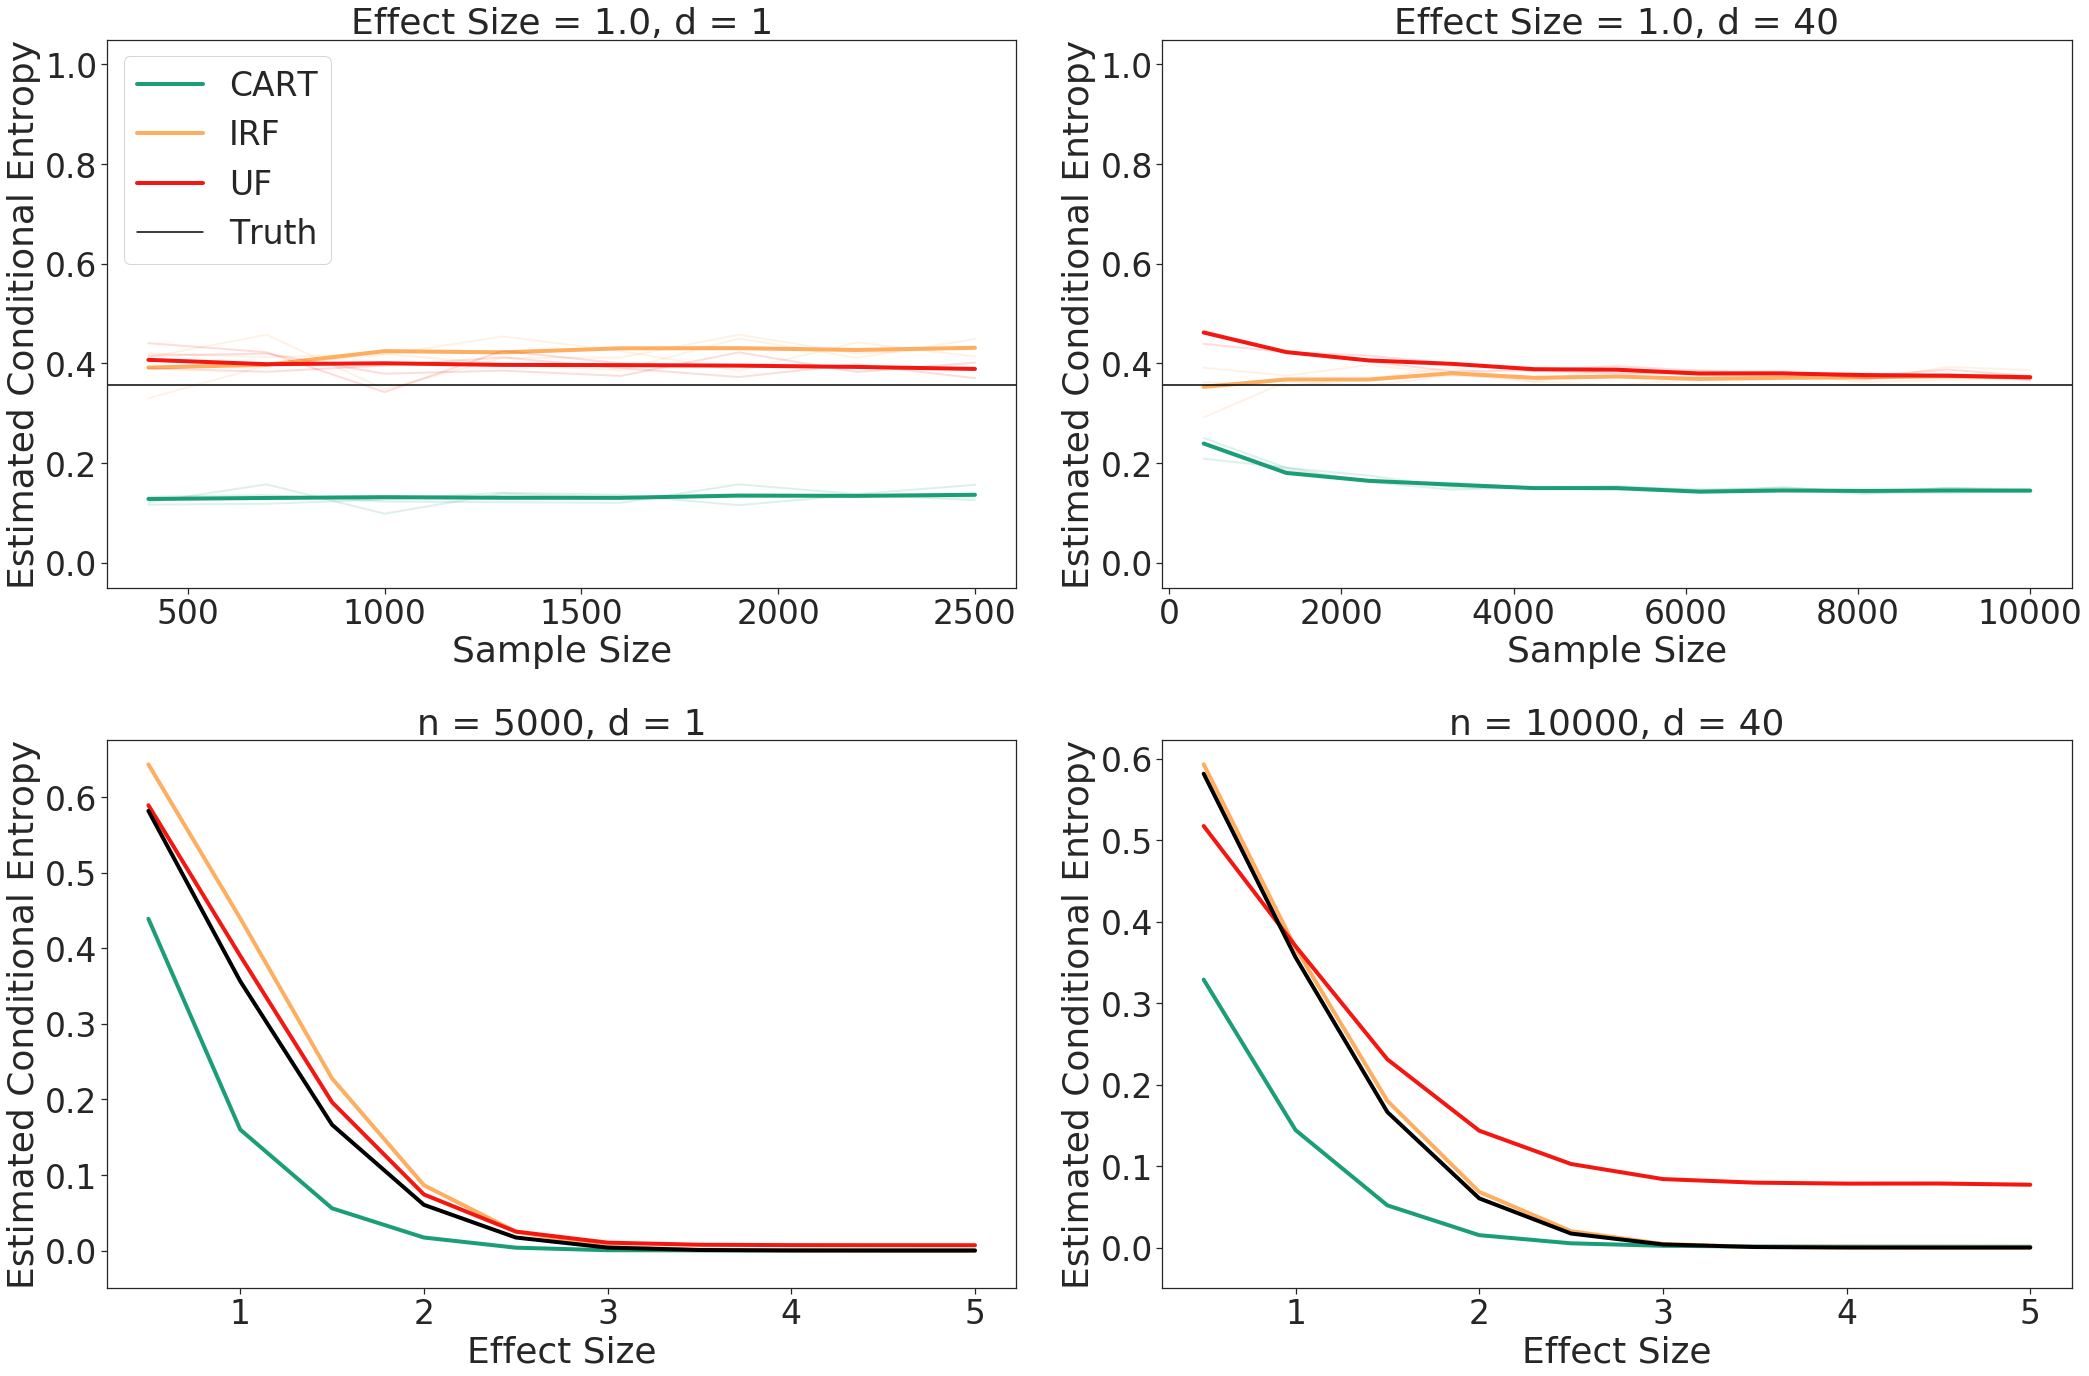

In [21]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size)